In [13]:
import numpy as np
import pickle
from tqdm.notebook import tqdm
from helpers import Peak, Evaluator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import History
from keras.callbacks import TensorBoard

In [14]:
with open('data.pkl', 'rb') as inp:
    data = pickle.load(inp)
data[0]

{'params': {'U': 1.8727005942368125,
  'peaks': [Peak(center=0.9363502971184062, height=0.31959818254342154, width=1.397987726295555, shape='quadratic')]},
 'greens': [-0.23466203588187343,
  -0.05942099878960389,
  -0.024172145151897313,
  -0.012804251988179792,
  -0.007870873408746037,
  -0.005312565282969809,
  -0.003821921099771035,
  -0.0028793685451773375,
  -0.0022462672119989814,
  -0.0018008196542761718,
  -0.0014756716052139937,
  -0.0012311515943049444,
  -0.0010426734152604697,
  -0.0008943473235154833,
  -0.0007755365090402375,
  -0.0006789043995161015,
  -0.0005992587246119831,
  -0.0005328415334899645,
  -0.0004768789427881397,
  -0.00042928748364481727,
  -0.0003884777818849923,
  -0.00035322038627431235,
  -0.00032255224353523054,
  -0.0002957103369977793,
  -0.0002720838350810405,
  -0.00025117907744435445,
  -0.00023259360929982128,
  -0.00021599668763931437,
  -0.00020111447974161003,
  -0.0001877187064104281,
  -0.00017561784344615627,
  -0.00016465024344932718,
  

In [15]:
############ Read normalize and prepare the INPUT DATA
X = []
for datum in tqdm(data):
    X.append(datum['greens'])
X = np.array(X)
X.shape

(50000, 600)

In [16]:
## META PARAMETERS
layers = [1024, 1024]  # nb of neurons of each layer
nb_epochs = 10
name = 'initial'

## Variable to save the intermediate results
history = History()

########## Creation of the optimizer (adam) and the model 
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
# 2*N = nb of Re(G(iw_n)) and Im(G(iw_n)) = X.shape[1]
model.add(Dense(units=layers[0], input_dim=X.shape[1]))  
for nb_neurons in layers[1:]:
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=nb_neurons))
model.add(Activation('sigmoid'))  # softmax, relu
print("The model has been initiated with Sequential.")

########## Activate TensorBord in order to observe the evolution of the training live
tbCallBack = TensorBoard(log_dir='./TensorBoard/' + name, histogram_freq=0, write_graph=True, write_images=True)

############ Read normalize and prepare the OUTPUT DATA
y = []
ws = np.linspace(-5, 5, layers[-1])
for datum in tqdm(data):
    y.append(Peak.evaluate_all(datum['params']['peaks'], ws))
y = np.array(y)
y.shape

The model has been initiated with Sequential.


(50000, 1024)

In [17]:
## Train / Validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

######### Compile the model
model.compile(loss='mean_squared_error', # 'kullback_leibler_divergence',
        optimizer=adam,
        metrics=['mae'])

history = model.fit(X_train, y_train, 
                    epochs=nb_epochs,
                    initial_epoch=0,
                    batch_size=128,
                    validation_data=(X_test, y_test), 
                    callbacks=[tbCallBack])

Train on 33500 samples, validate on 16500 samples
Epoch 1/20
33500/33500 [==============================] - 8s 246us/step - loss: 0.0126 - mean_absolute_error: 0.0570 - val_loss: 0.0120 - val_mean_absolute_error: 0.0423
Epoch 2/20
33500/33500 [==============================] - 8s 231us/step - loss: 0.0028 - mean_absolute_error: 0.0241 - val_loss: 0.0070 - val_mean_absolute_error: 0.0348
Epoch 3/20
33500/33500 [==============================] - 8s 232us/step - loss: 0.0023 - mean_absolute_error: 0.0208 - val_loss: 0.0081 - val_mean_absolute_error: 0.0387
Epoch 4/20
33500/33500 [==============================] - 8s 234us/step - loss: 0.0021 - mean_absolute_error: 0.0189 - val_loss: 0.0079 - val_mean_absolute_error: 0.0366
Epoch 5/20
33500/33500 [==============================] - 8s 232us/step - loss: 0.0020 - mean_absolute_error: 0.0180 - val_loss: 0.0077 - val_mean_absolute_error: 0.0346
Epoch 6/20
33500/33500 [==============================] - 8s 242us/step - loss: 0.0018 - mean_absolu

In [18]:
######## Save the results
f_handle = open('output/' + str(name)+'_mae.csv', 'a')
np.savetxt(f_handle, history.history['mean_absolute_error'])
f_handle.close()
f_handle = open('output/' + str(name)+'_val_mae.csv', 'a')
np.savetxt(f_handle, history.history['val_mean_absolute_error'])
f_handle.close()

model.save('output/' + str(name)+'_model.h5')
model.save_weights('output/' + str(name)+'_weights.h5')

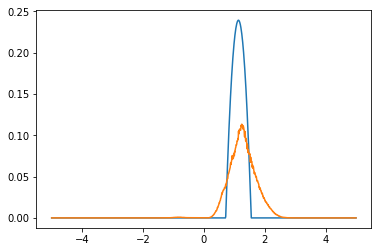

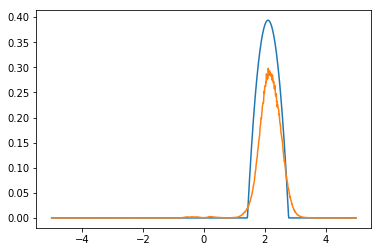

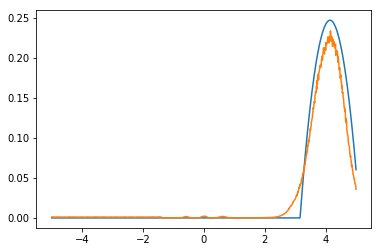

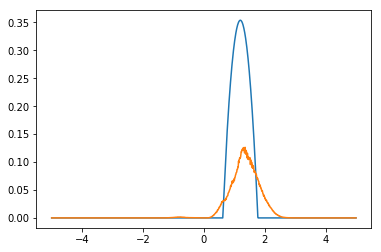

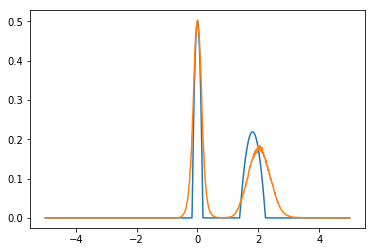

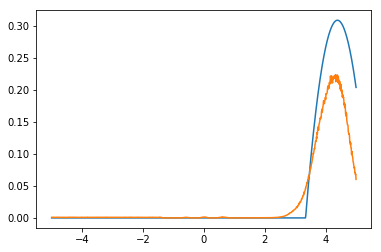

In [19]:
import matplotlib.pyplot as plt
class Evaluator2:
    @staticmethod
    def show(model, X, y, ws):
        y_pred = model.predict(np.array([X, ]))[0]
        plt.plot(ws, y)
        plt.plot(ws, y_pred)
        plt.show()
        
for i in range(3):
    Evaluator2.show(model, X_train[i], y_train[i], ws)
    Evaluator2.show(model, X_test[i], y_test[i], ws)
    

In [1]:
from helpers import Peak
import numpy as np
import pickle
from tqdm.notebook import tqdm
# from helpers import Peak, Evaluator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import History
from keras.callbacks import TensorBoard

with open('data.pkl', 'rb') as inp:
    data = pickle.load(inp)
data[0]

############ Read normalize and prepare the INPUT DATA
X = []
for datum in tqdm(data):
    X.append(datum['greens'])
X = np.array(X)
print(X.shape)

## META PARAMETERS
layers = [1024, 128, 64, 1024, 256]  # nb of neurons of each layer
nb_epochs = 500
name = 'initial'

## Variable to save the intermediate results
history = History()

########## Creation of the optimizer (adam) and the model 
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
# 2*N = nb of Re(G(iw_n)) and Im(G(iw_n)) = X.shape[1]
input_shape=(X.shape[1], 1)
for i in range(1, len(layers) - 2):
    nb_neurons = layers[i]
    print(nb_neurons, layers[i - 1])
    model.add(Conv1D(nb_neurons, 2, strides=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=(1)))
    model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=layers[-2], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=layers[-1]))
model.add(Activation('relu'))  # sigmoid, softmax, relu
print("The model has been initiated with Sequential.")

########## Activate TensorBord in order to observe the evolution of the training live
tbCallBack = TensorBoard(log_dir='./TensorBoard/' + name, histogram_freq=0, write_graph=True, write_images=True)

############ Read normalize and prepare the OUTPUT DATA
y = []
for datum in tqdm(data):
    # Forward U_max in data generation
    ws = np.linspace(0, 5, layers[-1])
    density = Peak.aggregate(datum['params']['peaks'], ws)
    # print(Peak.integral(density, ws))
    y.append(density)
y = np.array(y)
print(y.shape)

## Train / Validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# For Conv1D layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

######### Compile the model
model.compile(loss='mean_absolute_error', # 'kullback_leibler_divergence',
        optimizer=adam,
        metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, 
                    epochs=nb_epochs,
                    initial_epoch=0,
                    batch_size=128,
                    validation_data=(X_test, y_test), 
                    callbacks=[tbCallBack])

######## Save the results
output_dir = 'output_'
# f_handle = open(output_dir + str(name)+'_mae.csv', 'a')
# np.savetxt(f_handle, history.history['mean_absolute_error'])
# f_handle.close()
# f_handle = open(output_dir + str(name)+'_val_mae.csv', 'a')
# np.savetxt(f_handle, history.history['val_mean_absolute_error'])
# f_handle.close()

plt.figure()
plt.plot(history.history['mean_absolute_error'], label='Train')
plt.plot(history.history['val_mean_absolute_error'], label='Test')
plt.legend()
plt.show()

model.save(output_dir + str(name)+'_model.h5')
model.save_weights(output_dir + str(name)+'_weights.h5')

import matplotlib.pyplot as plt
class Evaluator2:
    @staticmethod
    def show(model, X, y, ws):
        y_pred = model.predict(np.array([X, ]))[0]
        plt.plot(ws, y)
        plt.plot(ws, y_pred)
        plt.show()
        
for i in range(3):
    Evaluator2.show(model, X_train[i], y_train[i], ws)
    Evaluator2.show(model, X_test[i], y_test[i], ws)

Using TensorFlow backend.



(50000, 600)
128 1024
64 128
The model has been initiated with Sequential.



(50000, 256)
Train on 33500 samples, validate on 16500 samples
Epoch 1/500
 4736/33500 [===>..........................] - ETA: 3:43 - loss: 0.0862 - mean_absolute_error: 0.0862

KeyboardInterrupt: 